In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

# Monte Carlo Control

So far, we assumed that we know the underlying model of the environment and that the agent has access to it. 
Now, we considere the case in which do not have access to the full MDP. That is, we do __model-free prediction__ now.

To illustrate this, we implement the black jack example from the RL Lecture 5 by Davin Silver for Monte Carlo Control [see example](https://youtu.be/0g4j2k_Ggc4?t=2193)

We use Monte-Carlo policy evaluation based on the action-value function $Q=q_\pi$ and then a $\epsilon$-greedy exploration (greedy exploration with probability to choose a random move).

Remember: $ G_t = R_{t+1} + \gamma R_{t+2} + ... + \sum_{k=0} \gamma^k \cdot R_{t+k+1}$

__Algorithm:__
* Update $V(s)$ incrementally after each episode
* For each state $S_t$ with return $G_t$ do:
    * $N(S_t) \gets N(S_t) +1$
    * $Q(S_t,A_t) \gets Q(S_t,A_t) + \frac{1}{N(S_t)} \cdot (G_t - V(S_t,A_t))$
        * Which corresponds to the _actual return_ ($G_t$) - the _estimated return_ ($Q(S_t,A_t)$)
        * $\frac{1}{N(S_t)}$ is a weighting factor that let us forget old episodes slowly
* Improve policy based on new action-value function
    * $\epsilon \gets \frac{1}{k}$
    * $\lambda \gets \epsilon-greedy(Q)$

MC converges to solution with minimum mean squared error.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import plotting
from operator import itemgetter
plotting.set_layout(drawing_size=15)


## The Environment

For this example we use the python package [gym](https://gym.openai.com/docs/) which provides a ready-to-use implementation of a BlackJack environment.

The states are stored in this tuple format: \n(Agent's score , Dealer's visible score, and whether or not the agent has a usable ace)

Here, we can look at the number of different states:

In [3]:
import gym
env = gym.make('Blackjack-v0')
env.observation_space

Tuple(Discrete(32), Discrete(11), Discrete(2))

And the number of actions we can take:

In [4]:
env.action_space

Discrete(2)

To start a game call `env.reset()` which will return the obersavtion space

In [5]:
env.reset()

(19, 3, False)

We can take two different actions: `hit` = 1 or `stay` = 0. 

The result of this function call shows the _obersavtion space_, the reward (winning=+1, loosing =-1) and if the game is over, 

In [6]:
env.step(1)

((24, 3, False), -1.0, True, {})

## Define the Agent



In [38]:

class agents():
    """ This class defines the agent 
    """
    
    def __init__(self, state_space, action_space, ):
        """ TODO """ 
        
        # Store the discount factor 
        self.gamma = 0.7
        # Store the epsilon parameters
        self.epsilon = 1
        
        n_player_states = state_space[0].n
        n_dealer_states = state_space[1].n
        n_usable_ace = state_space[0].n
        
        # two available actions stay (0) and hit (1)
        self.actions = list(range(action_space.n))
        
        # Store the action value function for each state and action
        self.q = np.zeros((n_player_states,n_dealer_states,n_usable_ace, action_space.n))
        
        # incremental counter for a state
        self.N = np.zeros((n_player_states,n_dealer_states,n_usable_ace,action_space.n))
        

    
    def greedy_move(self,s, k_episode):
        # given a state return the next move according to epsilon greedy algorithm
        
        # find optimal action a^*
        v_a = []
        for i_a,a in enumerate(self.actions):
            # get value for action state pair
            s2 = 1 if s[2] else 0
            v = self.q[s[0],s[1],s2,a]
            v_a.append((v,a))
        
        # get action with maximal value
        a_max = max(v_a,key=itemgetter(0))[1]
        
        # with probabiliyt 1-eps execute the best action otherwise choose other action
        if np.random.rand() < (1-self.epsilon):
            a = a_max
        else:
            a = int(not a_max)
        
        # decrement epsilon
        self.epsilon = 1/(k_episode)
        
        return a
    
    
    def incre_counter(self, state, action):
        # Increments the counter for a given state and action 
        
        # convert the true/false state to 0/1
        s2 = 1 if state[2] else 0
        # increment the counter for that state
        self.N[state[0],state[1],s2,action] += 1
        
    def get_counter(self, state, action):
        # convert the true/false state to 0/1
        s2 = 1 if state[2] else 0
        # increment the counter for that state
        return self.N[state[0],state[1],s2,action]
    
    def policy_evaluation(self,all_states,all_rewards, all_actions):
        # Update V(s) incrementally 
        for i_s,s in enumerate(all_states):
            
            # get corresponding action for given state
            a = all_actions[i_s]
            
            # convert the true/false state to 0/1
            s2 = 1 if s[2] else 0
            # Get the value function for that state
            Q_s = self.q[s[0],s[1],s2,a]
            # calculate the total reward
            G = np.sum([agent.gamma**k * r for k,r in enumerate(all_rewards)])
            # Update the value funtion
            self.q[s[0],s[1],s2,a] = Q_s + 1/self.get_counter(s,a) * (G - Q_s)
    


In [39]:
# how many episodes should be played
n_episodes = 500000
# initialize the agent. let it know the number of states and actions
agent = agents(env.observation_space, env.action_space)

# Incremental MC updates
# Play one episode then update V(s)
for i in range(n_episodes):
    all_states = []
    all_rewards = []
    all_actions = []
    
    # start the game
    s = env.reset()
    

    # play until environment tells you that the game is over
    game_ended = False
    while not game_ended:
        # increment counter
        
        # choose a movement according to eps-greedy algorithm and update policy
        move = agent.greedy_move(s,i+1)
        
        # use the old state for evaluation
        all_states.append(s)
        # increment the counter for a given state and action
        agent.incre_counter(s,move)
        # move
        s,r,game_ended,_ = env.step(move)
    
        # save everything
#         all_states.append(s)
        all_rewards.append(r)
        all_actions.append(move)
        

        # Evaluate policy
    agent.policy_evaluation(all_states,all_rewards,all_actions)
        
        ### END OF EPISODE ###




## Plotting

<ipython-input-40-7f66e47054f4>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(range(13,22))
<ipython-input-40-7f66e47054f4>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(range(1,11,2))
<ipython-input-40-7f66e47054f4>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(range(13,22))
<ipython-input-40-7f66e47054f4>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(range(1,11,2))


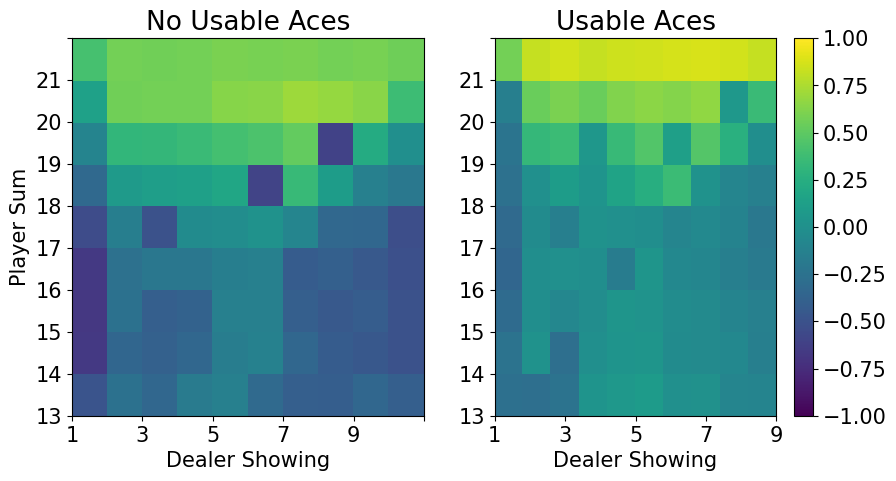

In [40]:
fig = plt.figure(figsize=(10,5))

axes = fig.subplots(1,2,squeeze=False)

ax = axes[0,0]


c = ax.pcolormesh(agent.q[13:22,1:,0,:].max(2),vmin=-1,vmax=1)
ax.set_yticklabels(range(13,22))
ax.set_xticklabels(range(1,11,2))
ax.set_xlabel('Dealer Showing')
ax.set_ylabel('Player Sum')
ax.set_title('No Usable Aces')
# plt.colorbar(c)

ax = axes[0,1]
c = ax.pcolormesh(agent.q[13:22,1:,1,:].max(2),vmin=-1,vmax=1)
ax.set_yticklabels(range(13,22))
ax.set_xticklabels(range(1,11,2))
ax.set_title('Usable Aces')
ax.set_xlabel('Dealer Showing')
plt.colorbar(c)

plt.show()



<ipython-input-41-ea3605012f37>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(range(13,22))
<ipython-input-41-ea3605012f37>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(range(1,11,2))
<ipython-input-41-ea3605012f37>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(range(13,22))
<ipython-input-41-ea3605012f37>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(range(1,11,2))


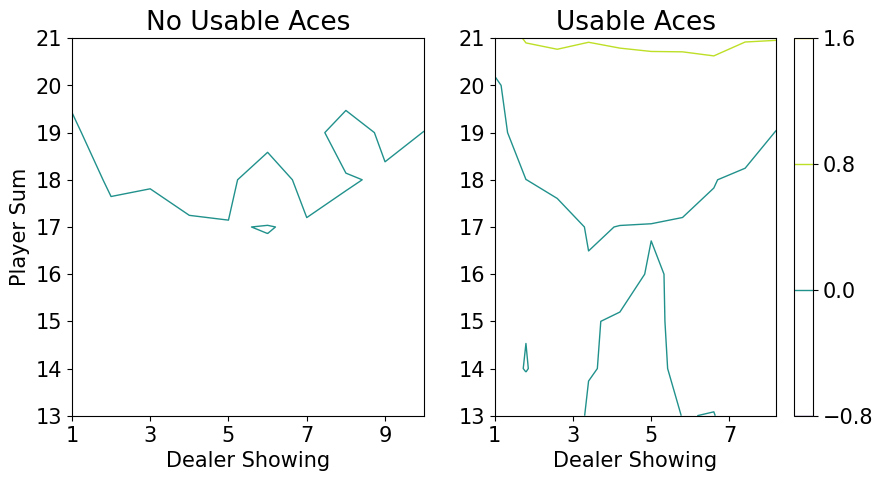

In [41]:
fig = plt.figure(figsize=(10,5))

axes = fig.subplots(1,2,squeeze=False)

ax = axes[0,0]


c = ax.contour(agent.q[13:22,1:,0,:].max(2),levels=1,vmin=-1,vmax=1)
ax.set_yticklabels(range(13,22))
ax.set_xticklabels(range(1,11,2))
ax.set_xlabel('Dealer Showing')
ax.set_ylabel('Player Sum')
ax.set_title('No Usable Aces')
# plt.colorbar(c)

ax = axes[0,1]
c = ax.contour(agent.q[13:22,1:,1,:].max(2),levels=1,vmin=-1,vmax=1)
ax.set_yticklabels(range(13,22))
ax.set_xticklabels(range(1,11,2))
ax.set_title('Usable Aces')
ax.set_xlabel('Dealer Showing')
plt.colorbar(c)

plt.show()